# Binary Classification
## Loan Default Prediction: A Neural Network Approach
In this notebook, we create a vanilla neural network and apply it to a real-world dataset.

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib
plt.rcParams['figure.figsize'] = 12,7
plt.rcParams.update({'font.size': 16})

# Seaborn
sns.set_style('whitegrid')
sns.set_palette("PuBuGn_d")

## Model Evaluation
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report

### Data
The data that we will be using comes from the Lending Club Company -- a peer-to-peer lending company. The data contains various features describing the loans issued through the said company.

Standardization: It is always a good practice to standardize the numerical features so that any numerical computations during training will be executed in a fast manner since we will be able to avoid operations involving significantly large values.

Note that the proper way to standardize the test set is to use the parameters ($\mu$ and $\sigma$) from the training set. This is to ensure that any predictions on unseen data will still be scored relative to how the model was trained.

In [2]:
def standardize_df(
    df_in : pd.DataFrame,
    mean_in : np.array,
    std_in : np.array,
) -> pd.DataFrame:
    """Standardize df_in based on the training mean and std.
    """
    return (df_in.reset_index(drop=True) - mean_in.to_numpy()) / std_in.to_numpy()
    
    
def data_processing(
    data_folder: str='Data/Loan Prediction',
    shuffle: bool=True,
    val_perc: float=0.2
) -> list:
    """Function to read and process the loan prediction dataset.
    
    Parameters:
    -----------
    data_folder : str
        The root folder where the .csv files are located.
    shuffle : boolean
        If true, shuffles the training dataset.
    val_perc : float [0,1]
        Fraction of the training data to be used as validation set.
    
    Returns:
    --------
    X_train, X_test, X_val, y_train, y_val, y_test : pd.DataFrame
    """
    # Read the csv files
    X_train = pd.read_csv(os.path.join(data_folder, 'X_train.csv'))
    X_test  = pd.read_csv(os.path.join(data_folder, 'X_test.csv'))
    y_train = pd.read_csv(os.path.join(data_folder, 'y_train.csv'))
    y_test  = pd.read_csv(os.path.join(data_folder, 'y_test.csv'))
    
    # Shuffle training
    X_train = X_train.sample(frac=1, random_state=42)
    y_train = y_train.iloc[X_train.index, :]
    
    # Reset index
    X_train.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    
    # Fill NaNs with zeroes
    X_train.fillna(0, inplace=True)
    X_test.fillna(0, inplace=True)
    
    # Get validation set
    X_val = X_train.sample(frac=val_perc)
    y_val = y_train.iloc[X_val.index.values, :]
    
    X_train = X_train.iloc[~X_train.index.isin(X_val.index), :].copy()
    y_train = y_train.iloc[~y_train.index.isin(X_val.index), :].copy()
    
    # Standardize data based on training dataset only
    # Get the mean and std
    mean_train, std_train = X_train.mean(), X_train.std()
    
    X_train = standardize_df(X_train, mean_train, std_train)
    X_val = standardize_df(X_val, mean_train, std_train)
    X_test = standardize_df(X_test, mean_train, std_train)
    
    return X_train.to_numpy(), X_val.to_numpy(), X_test.to_numpy(), y_train.to_numpy(), y_val.to_numpy(), y_test.to_numpy()

## Building the Model
For simplicity, we would just create a "Vanilla" Neural Network.

Here is the outline of the model architecture that we intend to build:
- 1 input layer (22 features)
- 1 densely connected (hidden) layer (hidden nodes = (2/3)*input_features)
- 1 output layers (densely connected layer with 1 output node)
    - sigmoid activation function
- Mini batch SGD optimizer

<i>Rule of Thumb: https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw#:~:text=The%20number%20of%20hidden%20neurons,size%20of%20the%20input%20layer. </i>

### Compiling the Model

Since we will be dealing with binary classifications (probability values within 0 and 1), our loss function should be <b>Binary Crossentropy</b>. 

$$
L_{\text{Cross_Entropy}} = -\left[y \ln(p) + (1-y) \ln(1-p)\right]
$$

where $y$ can only be $0$ or $1$, and $p$ is predicted probability

### Fitting the Model

Note on Epoch and Batch
- <b> Epoch </b> - One pass through all the rows in the training dataset
- <b> Batch </b> - One or more samples considered by the model within an epoch before weights are updated

<i> machinelearningmastery.com/tutorial-first-neural-network-python-keras/ </i>

As all Neural Network Models, the training process will run for a number of iterations through the entire dataset (this is called the epoch). We do not update the weights of the model for each data/row, but are updated based on the loss of an entire batch (average). Note that the lower the batch size and the higher the epoch values, the longer the computation.

#### Validation

It is important to determine the performance of our model to unseen data. We then need to split our training set further to accommodate the validation set.

In [3]:
# Define the sigmoid activation function with clipping to prevent overflow
def sigmoid(x):
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

# Define the derivative of the sigmoid function
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Define the softmax activation function
def softmax(x): # Include in slides
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

# Define the ReLU activation function
def relu(x): # ReLU
    return np.maximum(0, x)

# Define the derivative of the ReLU function
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Define the cross-entropy loss function for multi-class classification
def cross_entropy(y_true, y_pred): # Include in slides
    m = y_true.shape[0]
    y_pred = np.clip(y_pred, 1e-12, 1 - 1e-12)
    loss = -np.sum(y_true * np.log(y_pred)) / m
    return loss

# Define the derivative of cross-entropy loss with softmax function
def cross_entropy_derivative(y_true, y_pred):
    return y_pred - y_true

# Define the vanilla neural network class
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        np.random.seed(42)
        # Use He initialization for weights
        self.weights1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
        self.weights2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
        self.bias1 = np.zeros((1, hidden_size))
        self.bias2 = np.zeros((1, output_size))

    def feedforward(self, X):
        self.hidden = sigmoid(np.dot(X, self.weights1) + self.bias1)
        output = sigmoid(np.dot(self.hidden, self.weights2) + self.bias2)
        return output

    def backpropagation(self, X, y, output, learning_rate):
        d_output = cross_entropy_derivative(y, output)
        error_hidden_layer = d_output.dot(self.weights2.T)
        d_hidden_layer = error_hidden_layer * sigmoid_derivative(self.hidden)
        
        self.weights2 -= self.hidden.T.dot(d_output) * learning_rate
        self.weights1 -= X.T.dot(d_hidden_layer) * learning_rate
        self.bias2 -= np.sum(d_output, axis=0, keepdims=True) * learning_rate
        self.bias1 -= np.sum(d_hidden_layer, axis=0, keepdims=True) * learning_rate

    def train(self, X, y, epochs, learning_rate, batch_size, X_val=None, y_val=None):
        # Placeholders for training curve
        self.epoch_array = []
        self.training_loss_array = []
        self.val_loss_array = []
            
        for epoch in range(epochs):
            # Shuffle the data at the beginning of each epoch
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X = X[indices]
            y = y[indices]
            
            # Process mini-batches
            for start in range(0, X.shape[0], batch_size):
                end = start + batch_size
                Xi = X[start:end]
                yi = y[start:end]
                
                output = self.feedforward(Xi)
                self.backpropagation(Xi, yi, output, learning_rate)
            
            ## -- Capture training curve
            self.epoch_array.append(epoch)
            
            # Calculate training loss
            pred_train_epoch = self.feedforward(X)
            train_loss_epoch = cross_entropy(y, pred_train_epoch)
            self.training_loss_array.append(train_loss_epoch)
            
            if X_val is not None:
                pred_val_epoch = self.feedforward(X_val)
                val_loss_epoch = cross_entropy(y_val, pred_val_epoch)
                self.val_loss_array.append(val_loss_epoch)           
                
            if epoch % 20 == 0:
                print(f"Epoch {epoch}, Training Loss: {train_loss_epoch}, Validation Loss: {val_loss_epoch if X_val is not None else 'N/A'}")
                
    def plot_training_curve(self):
        fig, ax = plt.subplots()
        ax.plot(self.epoch_array, self.training_loss_array, linestyle="solid", color="blue", label="Training Loss")
        
        if self.val_loss_array:
            ax.plot(self.epoch_array, self.val_loss_array, linestyle="dashed", color="orange", label="Validation Loss")
            
        # Add labels
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Cross Entropy Loss")
        plt.legend(loc="best")
        
        plt.show()
        

    def predict(self, X):
        output = self.feedforward(X)
        predictions = (output > 0.5).astype(int)
        return predictions

In [8]:
# Load training data
X_train, X_val, X_test, y_train, y_val, y_test = data_processing()

# Define the neural network
nn = NeuralNetwork(input_size=X_train.shape[1], hidden_size=int(np.ceil((2/3)*X_train.shape[1])), output_size=1)

# Train the neural network using mini-batch SGD
nn.train(X_train, y_train, epochs=100, learning_rate=1e-5, batch_size=32, X_val=X_val, y_val=y_val)

Epoch 0, Training Loss: 0.48341281046775214, Validation Loss: 0.48670645834397536
Epoch 20, Training Loss: 0.27033099307457525, Validation Loss: 0.2722848365922338
Epoch 40, Training Loss: 0.22356307880911835, Validation Loss: 0.2255671409690121
Epoch 60, Training Loss: 0.17934853372475965, Validation Loss: 0.18145091406028205
Epoch 80, Training Loss: 0.14516428285640437, Validation Loss: 0.14733244195712478


### Get the training history to see if there is overfitting/underfitting

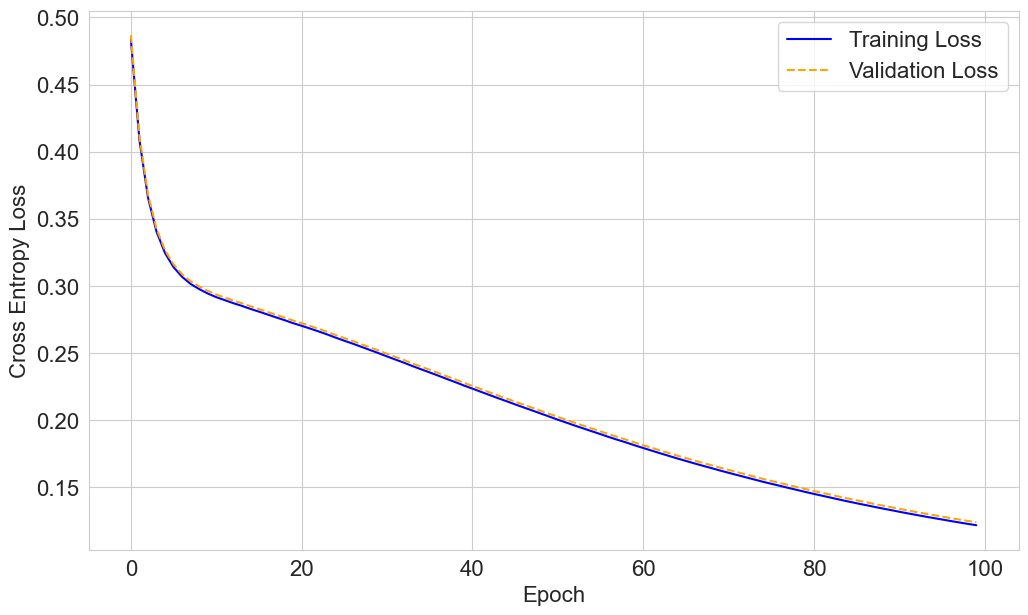

In [9]:
nn.plot_training_curve()

Since the Validation Curves (both in Loss and Accuracy) do not divert far from the training curve, we can be confident that there is no overfitting. The value of the accuracy also shows that we are not underfitting in the training and validation phase.

### On Unseen Data - Test Set

Binary Cross Entropy Loss (test): 0.1219
              precision    recall  f1-score   support

           0       0.94      0.88      0.91     16030
           1       0.92      0.96      0.94     23970

    accuracy                           0.93     40000
   macro avg       0.93      0.92      0.92     40000
weighted avg       0.93      0.93      0.93     40000



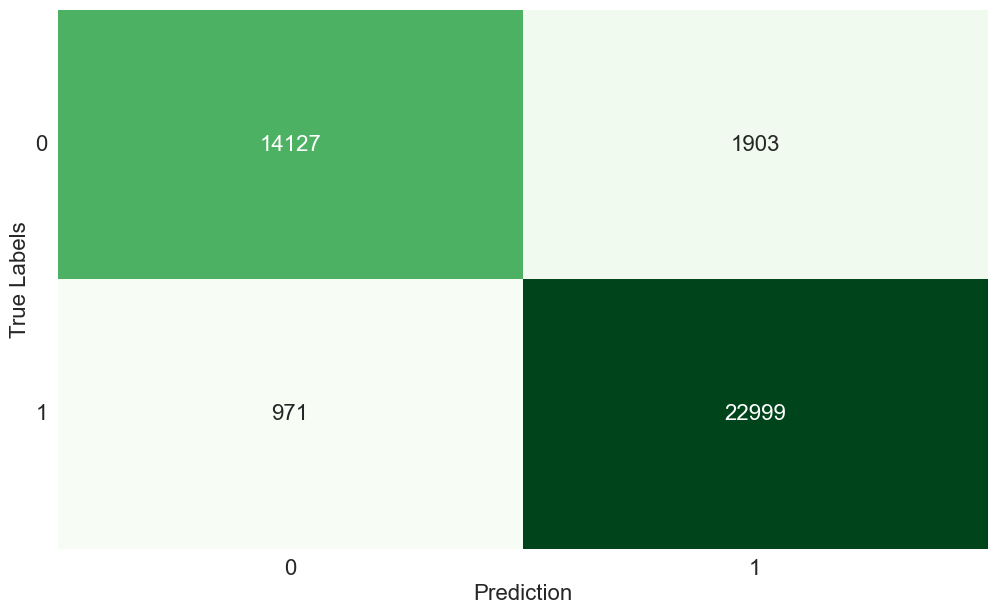

In [10]:
def performance_on_unseen(
    X_test: np.array=X_test,
    y_test: np.array=y_test
) -> None:
    """
    """
    # Predict the classes for the test data
    y_pred = nn.predict(X_test)

    print(f"Binary Cross Entropy Loss (test): {cross_entropy(y_test, nn.feedforward(X_test)):0.4f}")
    
    print(classification_report(y_test, y_pred))
    
    sns.heatmap(confusion_matrix(y_test, y_pred), cbar = False, annot=True, fmt='d', cmap='Greens')
    plt.xlabel('Prediction')
    plt.ylabel('True Labels')
    plt.yticks(rotation=0)
    plt.show()
    
performance_on_unseen(X_train,y_train)

Binary Cross Entropy Loss (test): 0.1241
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      3970
           1       0.93      0.96      0.94      6030

    accuracy                           0.93     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



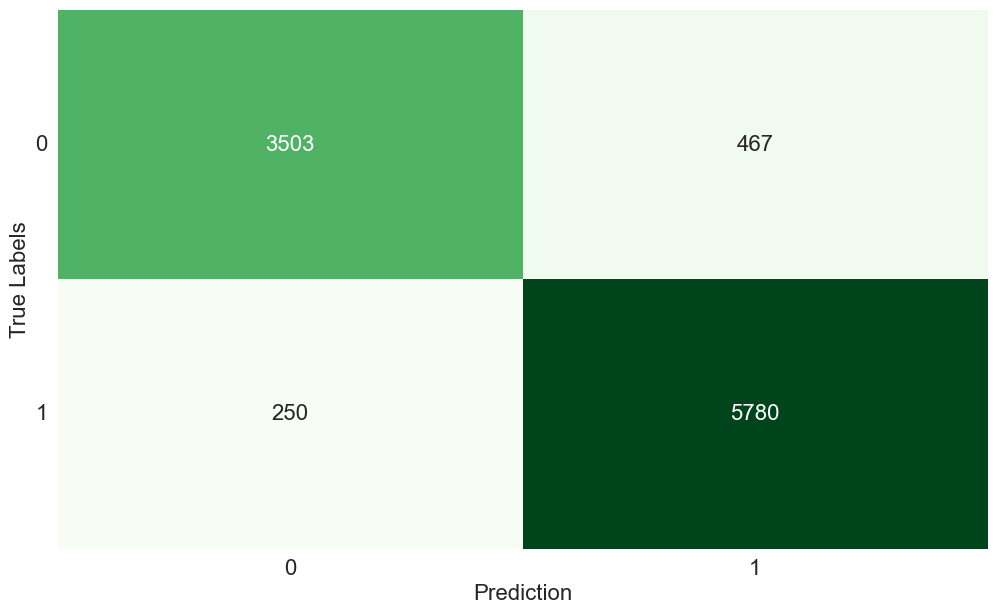

In [11]:
performance_on_unseen(X_val, y_val)

Binary Cross Entropy Loss (test): 0.1249
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       400
           1       0.93      0.96      0.95       600

    accuracy                           0.93      1000
   macro avg       0.94      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



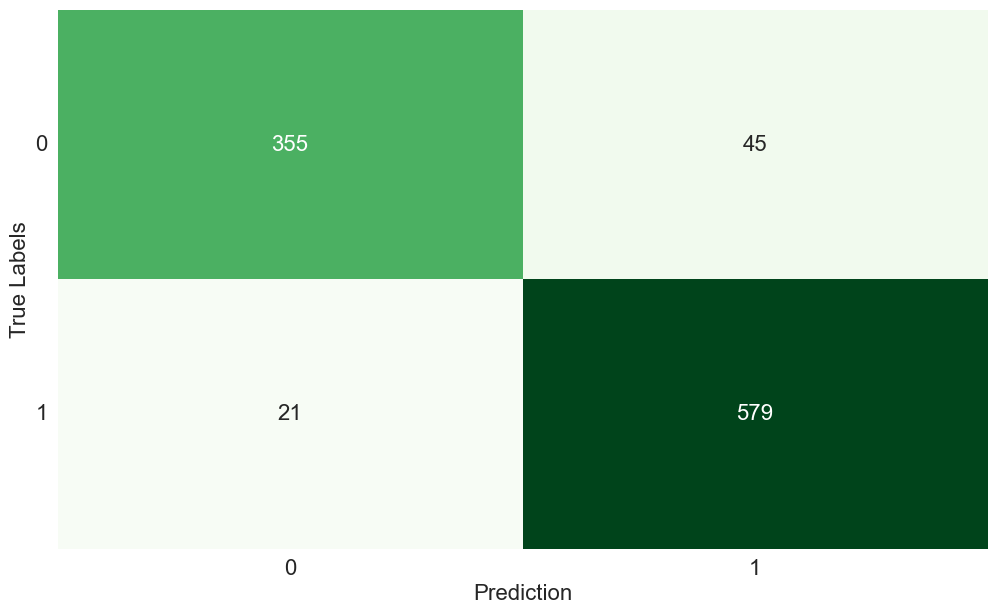

In [12]:
performance_on_unseen()

In [13]:
def roc_curve_plot(y_true, y_probs, lw = 3):
    """Plots the ROC curve for the prediction.
    """
    # Computes the false positive rates and true positive rates for different threshold
    fpr, tpr, _ =  roc_curve(y_true, y_probs)
    
    # Calculate area under the curve
    area = roc_auc_score(y_true, y_probs)
    
    # Plot 
    fig, ax = plt.subplots(figsize=(9,6))
    # Diagonal Line
    ax.plot([0,1], [0,1], lw = lw, ls = '-' , color='blue')
    
    # ROC
    ax.plot(fpr, tpr, ls = '-.', lw = lw, color='orange', label = 'ROC Curve (Area = {:0.2f})'.format(area))
    
    # Labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    
    sns.despine()
    plt.legend(loc='best')
    plt.show()

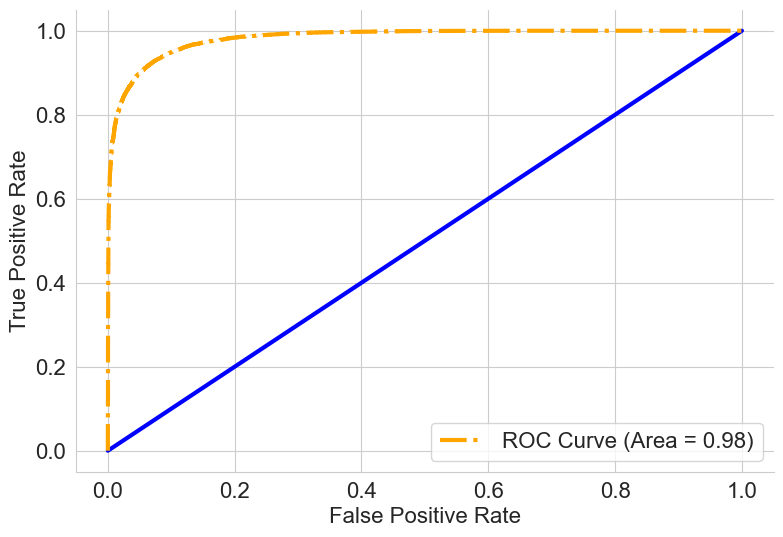

In [14]:
roc_curve_plot(y_train, nn.feedforward(X_train))